# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [3]:
USER_NAME = u"Кулагин".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print("Имплементируйте обучение логистической регрессии с %s регуляризацией \
    с помощью метода %s Stochastic Gradient Descent (SGD)"
      % (
          REGULARIZATIONS[hash(USER_NAME) % 2],
          ALGORITHM[hash(USER_NAME[::-1]) % 2]
      ))

Имплементируйте обучение логистической регрессии с L1 регуляризацией     с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w_i} =  \frac{1}{N}\left( \sigma(y^{(i)} g(x^{(i)}) - 1)\right)y^{(i)}x^{(i)} + \frac{1}{C} sign(w_i) $$

## Имплементация (5 баллов)

In [6]:
#%%pycodestyle
from sklearn.base import BaseEstimator, ClassifierMixin


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    @staticmethod
    def sigmoid(x, w):
        return 1 / (1 + np.exp(-np.dot(x, w)))

    def grad(self, x, y):
        sigma = self.sigmoid(x, self.w)

        grad = (sigma - y) * x + np.sign(self.w) / self.C

        return grad

    def loss(self, X):
        sigma = self.predict_proba(X)

        return np.mean(-y * np.log(sigma) - (1 - y) * np.log(1 - sigma))

    def __init__(self, alpha=0.01, C=1, max_epoch=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch

    def _fit(self, X, y=None):
        for epoch in range(self.max_epoch):
            self.epoch += 1

            speed = self.alpha / self.epoch

            for i in np.random.permutation(np.arange(X.shape[0])):
                self.w -= self.grad(X[i], y[i]) * speed

    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        X = np.c_[np.ones(X.shape[0]), X]

        self.epoch = 0
        self.w = np.random.rand(X.shape[1]) * 0.1
        self._fit(X, y)

        return self

    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        X = np.c_[np.ones(X.shape[0]), X]

        self._fit(X, y)

        return self

    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        X = np.c_[np.ones(X.shape[0]), X]

        y_hat = np.int((np.dot(X, self.w) > 0))

        return y_hat

    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X = np.c_[np.ones(X.shape[0]), X]

        y_hat_proba = self.sigmoid(X, self.w)

        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

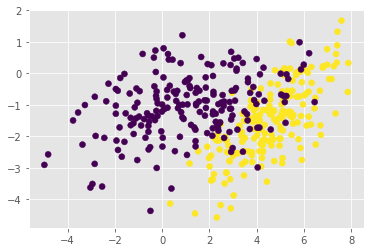

In [7]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:, 0], X[:, 1], c=y)

Веса: [-4.87057328  1.03314057 -1.1538478 ]


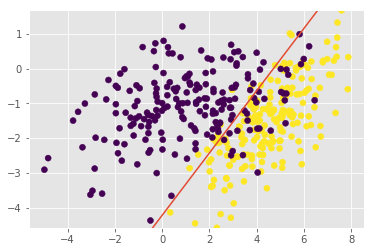

In [8]:
model = MySGDClassifier(alpha=2e-1, C=100, max_epoch=20)
model.fit(X, y)

xx = np.linspace(X[:, 0].min(), X[:, 0].max())
yy = -(model.w[0] + model.w[1]*xx) / model.w[2]

plt.ylim(X[:, 1].min(), X[:, 1].max())

plt.scatter(X[:, 0], X[:, 1], c=y)

plt.plot(xx, yy)

print("Веса:", model.w)

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [9]:
from sklearn.datasets import make_classification

In [10]:
X, y = make_classification(n_samples=10000, n_features=10,
                           n_informative=4, n_redundant=0,
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

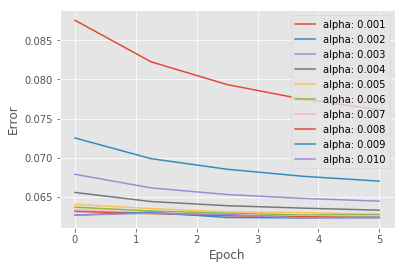

In [11]:
## Your Code Here
n_epoch = 5

for alpha in np.linspace(1e-3, 1e-2, 10):
    model = MySGDClassifier(alpha=alpha, C=100.0, max_epoch=1)
    model.fit(X, y)

    losses = np.zeros(n_epoch)

    for i in range(n_epoch):
        model.partial_fit(X, y)

        losses[i] = model.loss(X)

    plt.plot(np.linspace(0, n_epoch, n_epoch), losses,
             label='alpha: {:.3f}'.format(round(alpha, 3)))

plt.xlabel("Epoch")
plt.ylabel("Error")

plt.legend()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

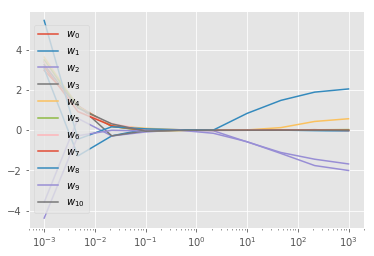

In [12]:
## Your Code Here
log_sp = np.logspace(3, -3, 10)

w = np.empty((len(log_sp), X.shape[1] + 1))

for i, c in enumerate(log_sp):
    model = MySGDClassifier(alpha=0.01, C=c, max_epoch=1)
    model.fit(X, y)

    w[i] = model.w

for n in range(X.shape[1] + 1):
    plt.plot(log_sp, w[:, n], label='$w_{%d}$' % n)

plt.xscale('log')

plt.legend()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [13]:
# Загрузка одной части данных
filepath = './data/trainingData_tabular/trainingData_tabular_chunk1.csv'
df_train_data = pd.read_csv(filepath, sep=',')

In [14]:
df_train_data.shape

(500000, 45)

In [15]:
# для удобства
df_train_data.columns = df_train_data.columns.str.replace('.', '_')
df_train_data = df_train_data.set_index('gamestate_id')

In [16]:
df_train_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [17]:
# Распределение классов
df_train_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [18]:
## Youd Code Here
print("Уникальных карт героя у игрока:",
      df_train_data['player_hero_card_id'].nunique())
print("Уникальных карт героя у оппонента:",
      df_train_data['opponent_hero_card_id'].nunique())

Уникальных карт героя у игрока: 9
Уникальных карт героя у оппонента: 9


In [19]:
df_train_data = pd.get_dummies(
    df_train_data, columns=['player_hero_card_id', 'opponent_hero_card_id'])

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [20]:
## Youd Code Here
X = np.float32(df_train_data.iloc[:, 1:].values)
y = np.float32(df_train_data.iloc[:, 0].values)

In [21]:
X.shape

(500000, 59)

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model = Pipeline(
    [
        ('sscaler', StandardScaler()),
        ('model', MySGDClassifier(max_epoch=1,
                                  C=100, alpha=1e-3))
    ]
)

model.fit(X, y)

Pipeline(memory=None,
     steps=[('sscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', MySGDClassifier(C=100, alpha=0.001, max_epoch=1))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [23]:
## Youd Code Here
filepath = './data/deprecated_testData_tabular/testData_tabular_chunk5.csv'

df_test_data = pd.read_csv(filepath, sep=',')

df_test_data.columns = df_test_data.columns.str.replace('.', '_')
df_test_data = df_test_data.set_index('gamestate_id')

In [24]:
df_test_data = pd.get_dummies(
    df_test_data, columns=['player_hero_card_id', 'opponent_hero_card_id'])

In [25]:
df_test_data.head().T

gamestate_id,1304374,4383331,3544947,4282915,4327924
decision,NaN,NaN,NaN,NaN,NaN
turn,5.0,9.0,16.0,3.0,5.0
opponent_armor,0.0,0.0,0.0,0.0,0.0
opponent_attack,0.0,3.0,0.0,0.0,0.0
opponent_hp,23.0,16.0,16.0,30.0,30.0
opponent_special_skill_used,0.0,0.0,1.0,0.0,0.0
opponent_weapon_durability,0.0,1.0,0.0,0.0,0.0
opponent_crystals_all,4.0,8.0,10.0,2.0,4.0
opponent_crystals_current,0.0,3.0,2.0,2.0,1.0
opponent_deck_count,21.0,17.0,9.0,24.0,22.0


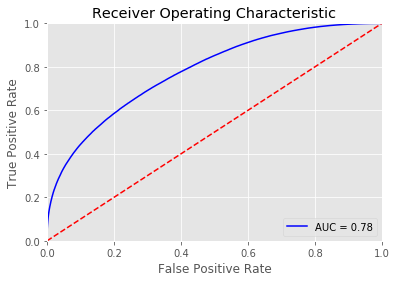

In [26]:
from sklearn.metrics import roc_curve, auc

X_test = np.float32(df_test_data.iloc[:, 1:].values)
y_test = np.loadtxt('data/deprecated_testLabels.txt')
y_test = y_test[:X_test.shape[0]]

# from http://code.i-harness.com/ru/q/17d9c84
preds = model.predict_proba(X_test)

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()